# Simple Dataset Manipulation

This notebook represents a simple way to get data from the dataset.

Loading Libraries and Creating Function to load the dataset from the json file, as a Dictionary.

In [27]:
import numpy as np
import copy
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation
np.set_printoptions(threshold=np.infty)
from utils_data_elab import VIC_OFF_X, VIC_OFF_Y, get_scenes, scene, obstacle, run, get_obs_info, get_scene_index

path_to_json = "/home/walter/graphrnn-mmw-denoising/data/"

def list_dataset(path):
    paths = []
    for p in os.listdir(path):
        if "maps" not in p and \
            ".csv" not in p and \
            "scene" not in p: paths.append(p)
    return paths

def dict_dataset(path):
    paths = {}
    for p in sorted(os.listdir(path)):
        if "maps" not in p and \
            ".csv" not in p and \
            "ignore" not in p and \
            "compress" not in p and \
            "scene" not in p and \
            os.path.isdir(os.path.join(path, p)): 
            # print(p.replace('run_', ''))
            x = str(int(p.replace('run_', '')))
            paths[x] = "run_"+x
    return paths

def open_json(path_to_run, run, verbose=True):
    if verbose: print(" Loading Dataset: ", run)
    # json_path = path_to_run+run.replace('_', '')+"/dataset_"+run+".json"
    json_path = path_to_run+run+"/dataset_"+run+".json"
    json_path = os.path.join(os.getcwd(), json_path)
    with open(json_path) as json_file:
        data = json.load(json_file)

    if verbose:
        print("\n Available Data: ")
        for key in data.keys(): print("  - ", key)
    return data


def apply_rototranslation(mmw_readings, poses, offset_x=VIC_OFF_X, offset_y=VIC_OFF_Y):
    assert len(poses) >= len(mmw_readings), "Number of poses must be greater or equal than number of point clouds, but got {} and {}".format(len(poses), len(mmw_readings))
    
    # Compute Pointcloud Transformation
    to_global = np.eye(4)
    abs_mmw = []
    for pc_o, pose in zip(np.copy(mmw_readings), np.copy(poses)):
        pc = pc_o[:, :3]

        # # pc = np.hstack( [ pc, np.ones( (pc_o.shape[0], 1) ) ]).T
        # # pose[:2] = np.subtract(pose[:2], [offset_x, offset_y])
        # # R = Rotation.from_euler('XYZ', [0,0, pose[2]]).as_matrix()
        # # to_global[:3, :3] = R
        # # to_global[:3, 3] = [pose[0], pose[1], 0.1]
        # # pc = np.matmul(to_global, pc).T

        pc = Rotation.from_euler('XYZ', [0,0, pose[2]]).apply(pc)
        pc = np.add(pc, [pose[0]-offset_x, pose[1]-offset_y, 0.1])
        
        pc_o[:, :3] = pc[:, :3]
        abs_mmw.append(pc_o)

    abs_mmw = np.vstack(abs_mmw)
    return abs_mmw

def plot_scene(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    fig.set_tight_layout(True)
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-3.5, 3.5])
    ax.set_ylim([-3.5, 3.5])
    ax.set_zlim([0, 1.5])
    ax.view_init(elev=90, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c=colors)
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], fake_points[:, 2], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], obstacles[:, 2], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], 0.1, s=path_size+5, marker='o', c='green')
        ax.scatter(path[1:-1, 0], path[1:-1,1], np.full(len(path)-2, 0.1), s=path_size, marker='.', c='green')
        ax.scatter(path[-1, 0], path[-1, 1], 0.1, s=path_size+5, marker='x', c='green')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)

def plot_2dscene(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    fig.set_tight_layout(True)
    ax = fig.add_subplot()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    ax.set_xlim([-3.5, 3.5])
    ax.set_ylim([-3.5, 3.5])
    # ax.set_zlim([0, 1.5])
    # ax.view_init(elev=90, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], s=pc_size, marker='.', c=colors)
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], 0.1, s=25, marker='o', c='orange')
        ax.scatter(path[1:-1, 0], path[1:-1,1], s=path_size, marker='.', c='orange')
        ax.scatter(path[-1, 0], path[-1, 1], 0.1, s=25, marker='x', c='orange')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)
    
def arena_filter(pc):
    return list(np.where(
            ((pc[:, 0] > -3.81) & (pc[:, 1] > -3.38) & (pc[:, 0] < 3.95) & (pc[:, 1] < 3.2) & (pc[:, 2] >= 0)) & \
            ((pc[:, 0] < -3.61) | (pc[:, 1] < -3.18) | (pc[:, 0] > 3.15) | (pc[:, 1] > 3.0) & (pc[:, 2] < 4))
        )[0])

def obstacles_filter(pc, obs_range_x, obs_range_y):
    t = []
    for i in range(obs_range_x.shape[0]):
        t.append(np.where((
            ((pc[:, 0] > obs_range_x[i, 0]) & (pc[:, 0] < obs_range_x[i, 1])) & \
            ((pc[:, 1] > obs_range_y[i, 0]) & (pc[:, 1] < obs_range_y[i, 1]))
        ))[0])
    t = np.hstack(t)
    return t

def update_refer_frame(mmw_readings, poses, offset_x=VIC_OFF_X, offset_y=VIC_OFF_Y):
    assert len(poses) >= len(mmw_readings), \
        "Number of poses must be greater or equal than number of point clouds, but got {} and {}".format(len(poses), len(mmw_readings))

    # Compute Pointcloud Transformation
    abs_mmw = []
    for pc_o, pose in zip(np.copy(mmw_readings), np.copy(poses)):
        pc = pc_o[:, :3]

        pc = np.add(pc, [(pose[0]-offset_x), (pose[1]-offset_y), 0.1])
        pc = np.matmul(pc, Rotation.from_euler('XYZ', [0., 0., pose[2]]).as_matrix())

        # pc_o[:, :3] = pc[:, :3]
        abs_mmw.append(pc)

    abs_mmw = np.vstack(abs_mmw)
    return abs_mmw

def obstacles_filter2(abs_mmw, pos, dims, tops, offset_x=VIC_OFF_X, offset_y=VIC_OFF_Y, verbose=False):

    tmp1 = np.array([False]*abs_mmw.shape[0])
    mmw_t = [abs_mmw[i:i+200] for i in range(0, abs_mmw.shape[0], 200)]

    i = 0
    for i in range(len(pos)):
        t = [[ 
            -(pos[i][0] - VIC_OFF_X), -(pos[i][1] - VIC_OFF_Y), (pos[i][2])
        ]]*(len(mmw_t))
        tmp_ = np.array(update_refer_frame(copy.deepcopy(mmw_t), copy.deepcopy(t), offset_x=0, offset_y=0))

        # print(" pos[0]: ", scenes[scene_index].obs[0])
        # # print(" pose: ", t)
        # print(" mmw_t: ", np.vstack(mmw_t).shape)
        # print(" mmw_readings:", abs_mmw.shape)
        # print(" tmp_:", np.shape(tmp_))
        if verbose:
            print(" obs: ", tops[i], "pos(t)", t[0], " dims: ", dims[i])
            print(" pos: ", pos[i])
        tmp2 = np.where((
            (
                (tmp_[:, 0] > -dims[i][0]/2) & \
                (tmp_[:, 0] < dims[i][0]/2) \
            ) & \
            (
                (tmp_[:, 1] > -dims[i][1]/2) & \
                (tmp_[:, 1] < dims[i][1]/2) \
            )
        ))[0]
        tmp1[tmp2] = True
        # dims[i, 2] *= 2
        # np.clip(np.linalg.norm(np.subtract(tmp_[not(tmp2), :2], dims[i, :2]/2)), 0, np.inf)
    return tmp1

def obstacles_filter3(abs_mmw, pos, dims, tops, offset_x=VIC_OFF_X, offset_y=VIC_OFF_Y, verbose=False):

    tmp1 = np.array([False]*abs_mmw.shape[0])
    mmw_t = [abs_mmw[i:i+200] for i in range(0, abs_mmw.shape[0], 200)]
    dist = np.array([False]*abs_mmw.shape[0])
    pos_off = np.subtract(pos, [offset_x, offset_y, 0.])
    pos_off[:, 0] = -pos_off[:, 0]
    pos_off[:, 1] = -pos_off[:, 1]

    mmw_abs = np.array(update_refer_frame(copy.deepcopy(mmw_t), copy.deepcopy(pos_off), offset_x=0, offset_y=0))

    i = 0
    for i in range(len(pos)):
        t = [[ 
            -(pos[i][0] - VIC_OFF_X), -(pos[i][1] - VIC_OFF_Y), (pos[i][2])
        ]]*(len(mmw_t))
        tmp_ = np.array(update_refer_frame(copy.deepcopy(mmw_t), copy.deepcopy(t), offset_x=0, offset_y=0))

        # print(" pos[0]: ", scenes[scene_index].obs[0])
        # # print(" pose: ", t)
        # print(" mmw_t: ", np.vstack(mmw_t).shape)
        # print(" mmw_readings:", abs_mmw.shape)
        # print(" tmp_:", np.shape(tmp_))
        if verbose:
            print(" obs: ", tops[i], "pos(t)", t[0], " dims: ", dims[i])
            print(" pos: ", pos[i])
        tmp2 = np.where((
            (
                (tmp_[:, 0] > -dims[i][0]/2) & \
                (tmp_[:, 0] < dims[i][0]/2) \
            ) & \
            (
                (tmp_[:, 1] > -dims[i][1]/2) & \
                (tmp_[:, 1] < dims[i][1]/2) \
            )
        ))[0]
        tmp1[tmp2] = True
        # dims[i, 2] *= 2
        # np.clip(np.linalg.norm(np.subtract(tmp_[not(tmp2), :2], dims[i, :2]/2)), 0, np.inf)
    return tmp1

def keep_borders(pc, dims, border):
    return list(np.where(
                ((pc[:, 0] > dims[0]/2-border) & (pc[:, 1] > dims[1]/2-border) |\
                 (pc[:, 0] < -dims[0]/2+border) & (pc[:, 1] < -dims[1]/2+border)) | \
                ((pc[:, 0] < -dims[0]/2+border) | (pc[:, 1] < -dims[1]/2+border) |\
                 (pc[:, 0] > dims[0]/2-border) | (pc[:, 1] > dims[1]/2-border))
        )[0])

# Generate random obstacles
def generate_abs_bounding_obstacle(i_pos, i_dims, n_points, border=0.03):
    obstacles_x = np.random.uniform(-i_dims[0]/2, i_dims[0]/2, n_points)
    obstacles_y = np.random.uniform(-i_dims[1]/2, i_dims[1]/2, n_points)
    obstacles_z = np.ones_like(obstacles_x)
    obstacles = np.column_stack([obstacles_x, obstacles_y, obstacles_z])
    obstacles = obstacles[keep_borders(obstacles, i_dims, border)]
    obstacles = obstacles.reshape(obstacles.shape[0], 1, 3)
    obs_poses = np.array([i_pos]*n_points)
    abs_obstacles = apply_rototranslation(obstacles, obs_poses)
    return abs_obstacles

def generate_abs_bounding_obstacles(pos, dims, tops, n_points, border=0.3):
    abs_obstacles = []
    for i in range(len(pos)):
        if "vicon/Obstacle" in tops[i] and not("vicon/ObstacleMonitor" in tops[i]):
            pos[i][2] += np.pi/2
        print(" Generating obstacle ", i, " at ", pos[i], "with topic ", tops[i])
        abs_obstacles.append(generate_abs_bounding_obstacle(pos[i], dims[i], n_points, border))

    abs_obstacles = np.vstack(abs_obstacles)
    return abs_obstacles


In [88]:
datasets = dict_dataset(path_to_json)
dataset_index = str(50)
run_path = "data/"
experiments_path = "experiments/"
data = json.load(open(run_path+"run_"+dataset_index+"/stacked_mmw_"+"run_"+dataset_index+".json"))
print("DATA KEYS: ", data.keys())

# print(" Loading: ", datasets[dataset_index])
# data = open_json(path_to_json, datasets[dataset_index], verbose=True)
data = data['labelled_mmw']
frame_10 = data[10]
point_10 = frame_10[10]
print("point_10:", point_10)

DATA KEYS:  dict_keys(['labelled_mmw'])
point_10: [1.4437310695648193, 0.2285025417804718, 0.04570050910115242, 23.100000381469727, 0.32749876379966736, 1.0, 0.0]


### Actually loading the dataset and creating:
### * `data`: dictionary containing the whole dataset. (When created, the keys will be shown)
### * `poses`: array of all the poses, for each timestamp
### * `mmw_readings`: list of numpy arrays. Each numpy array is a pointcloud containing, for each point, the intensity and the velocity along the point-sensor axis. 
### * `abs_mmw`: numpy array containing the pointcloud obtained by stacking all pointclouds captured during a run, in absolute coordinates. (With AHC points)
### * `raw_mmw`: same as `abs_mmw`, but without AHC points

In [25]:
# Load Dataset
datasets = dict_dataset(path_to_json)
dataset_index = str(51)
def load_dataset(datasets, dataset_index):
    print(" Loading: ", datasets[dataset_index])
    data = open_json(path_to_json, datasets[dataset_index], verbose=True)
    # obstacles = open_json(path_to_json,"obstacles_scene"+str(data["scene_ID"])+".json")

    # # Translate the obstacles in the inertial reference frame
    # obstacles = np.array([np.subtract(obstacles['x'],3), np.subtract(obstacles['y'],2.7),obstacles['z']]).T

    # Load Poses
    poses = np.vstack(data["data_pose"])

    #Load mmWave Data (organised by timestamp)
    mmw_readings = [np.atleast_2d(v) for v in data["data_mmwave"]]
    # mmw_readings_np = np.vstack(mmw_readings)
    abs_mmw = apply_rototranslation(copy.deepcopy(mmw_readings), poses)

    # Sometimes poses contain useless information, so we remove them
    poses = np.subtract(poses[:len(mmw_readings),:], [VIC_OFF_X, VIC_OFF_Y, 0.])
    return poses, abs_mmw, mmw_readings, data

poses, abs_mmw, mmw_readings, data = load_dataset(datasets, dataset_index)

 Loading:  run_51
 Loading Dataset:  run_51

 Available Data: 
  -  scene_ID
  -  init_pose
  -  run_total_time
  -  timestamp
  -  data_laser
  -  data_imu
  -  data_pose
  -  data_camera_image_path
  -  data_mmwave
  -  data_camera_depth_path
  -  missing_mmWave_idx


/home/walter/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


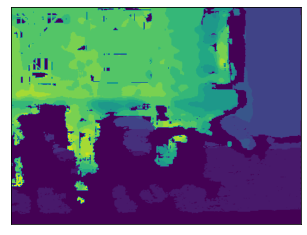

In [11]:
import cv2
img_path = path_to_json+"run_51/Image_depth/run51_framedepth190.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# plot image
plt.xticks([])
plt.yticks([])
plt.imshow(img, )


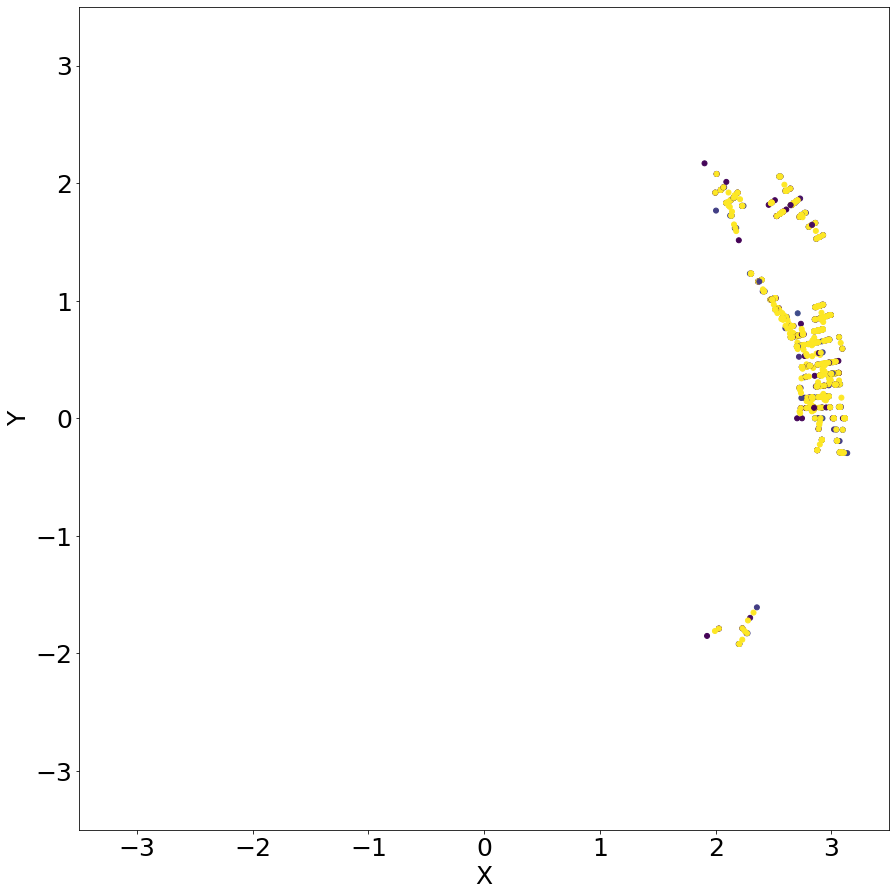

In [3]:
%matplotlib inline

def plot_scene2(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X', labelpad=25)
    ax.set_ylabel('Y', labelpad=25)
    ax.set_zlabel('Z', labelpad=25)
    ax.set_xticks([-3, -1.5, 0., 1.5, 3.])
    ax.set_yticks([-3, -1.5, 0., 1.5, 3.])
    ax.set_zticks([1.5, 3.])
    ax.set_xlim([0, 3.5])
    ax.set_ylim([-3.5, 3.5])
    ax.set_zlim([0, 3.])
    # ax.view_init(elev=90, azim=180)
    ax.view_init(elev=75, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c=colors)
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], fake_points[:, 2], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], obstacles[:, 2], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], 0.1, s=25, marker='o', c='orange')
        ax.scatter(path[1:-1, 0], path[1:-1,1], np.full(len(path)-2, 0.1), s=path_size, marker='.', c='orange')
        ax.scatter(path[-1, 0], path[-1, 1], 0.1, s=25, marker='x', c='orange')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)

# set text size to 10
mpl.rcParams['xtick.labelsize'] = 25
# set axis label size to 25
mpl.rcParams['font.size'] = 25
# print(mpl.rcParams.keys())
# plot_scene2(mmw_readings[14], pc_size=100, dest_path=path_to_json+"run_51/run_51_t10_window.png")
plot_2dscene(mmw_readings[14], pc_size=100)
    

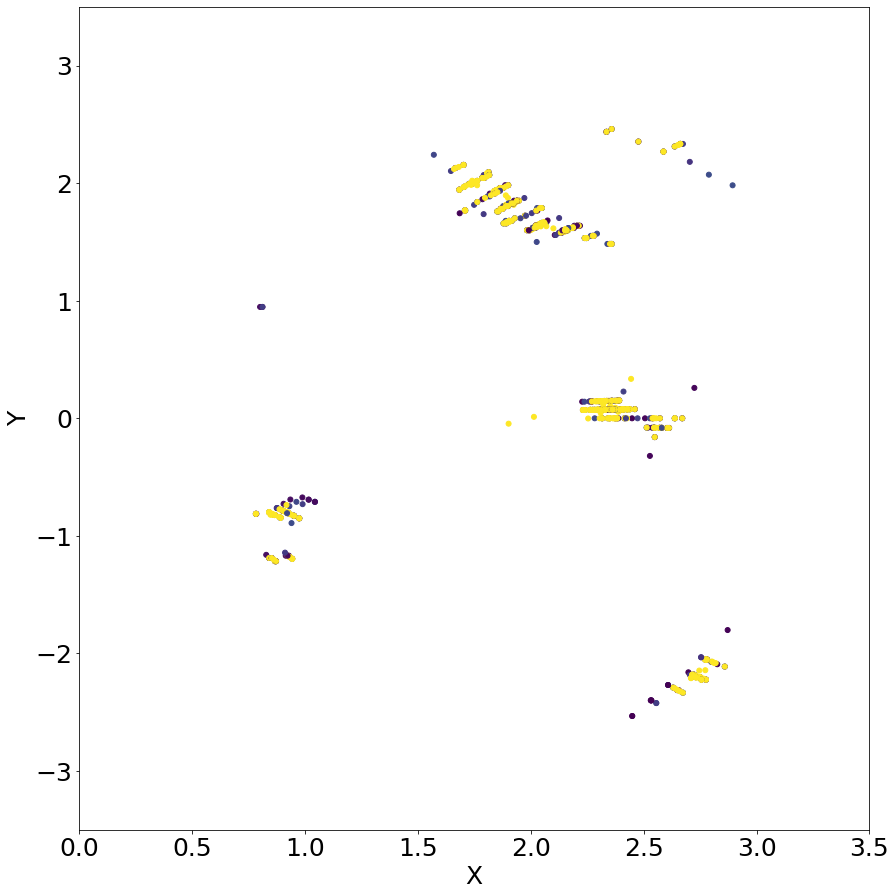

In [4]:

def plot_2dscene(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    fig.set_tight_layout(True)
    ax = fig.add_subplot()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    ax.set_xlim([0, 3.5])
    ax.set_ylim([-3.5, 3.5])
    # ax.set_zlim([0, 1.5])
    # ax.view_init(elev=90, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], s=pc_size, marker='.', c=colors)
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], 0.1, s=25, marker='o', c='orange')
        ax.scatter(path[1:-1, 0], path[1:-1,1], s=path_size, marker='.', c='orange')
        ax.scatter(path[-1, 0], path[-1, 1], 0.1, s=25, marker='x', c='orange')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)
    

i=50
# plot_2dscene(mmw_readings[i][np.where(mmw_readings[i][:, -2] != 255)], pc_size=100, dest_path=path_to_json+"run_51/run_51_t"+str(i)+"_without255.png")
# plot_2dscene(mmw_readings[i], pc_size=100, dest_path=path_to_json+"run_51/run_51_t"+str(i)+"_with255.png")
plot_2dscene(mmw_readings[i], pc_size=100,)


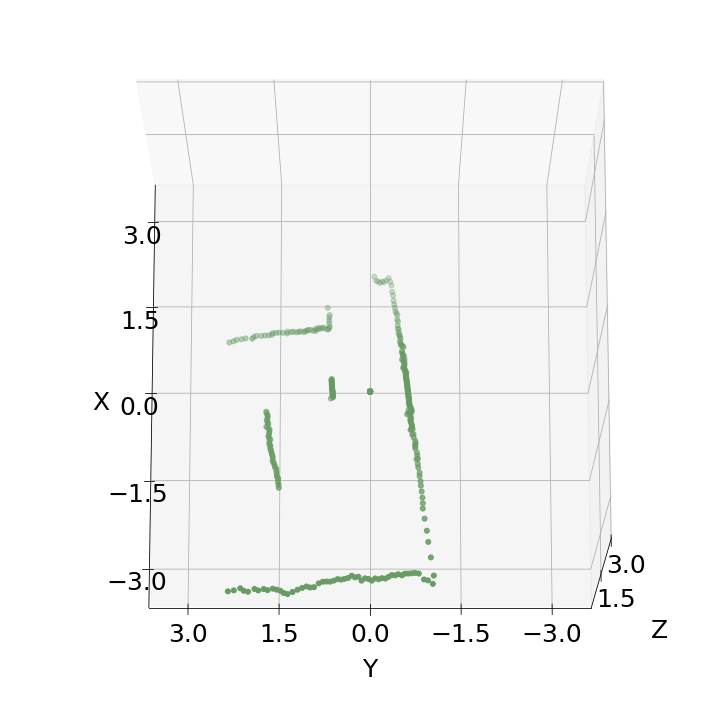

In [5]:
def plot_scene3(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X', labelpad=25)
    ax.set_ylabel('Y', labelpad=25)
    ax.set_zlabel('Z', labelpad=25)
    ax.set_xticks([-3, -1.5, 0., 1.5, 3.])
    ax.set_yticks([-3, -1.5, 0., 1.5, 3.])
    ax.set_zticks([1.5, 3.])
    ax.set_xlim([-3.5, 3.5])
    ax.set_ylim([-3.5, 3.5])
    ax.set_zlim([0, 3.])
    # ax.view_init(elev=90, azim=180)
    ax.view_init(elev=75, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c=colors)
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], fake_points[:, 2], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], obstacles[:, 2], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], 0.1, s=25, marker='o', c='orange')
        ax.scatter(path[1:-1, 0], path[1:-1,1], np.full(len(path)-2, 0.1), s=path_size, marker='.', c='orange')
        ax.scatter(path[-1, 0], path[-1, 1], 0.1, s=25, marker='x', c='orange')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)

data = open_json(path_to_json, datasets[dataset_index], verbose=False)
laser = data["data_laser"]
# print(laser[14])
# convert lidar distance data to x, y, z coordinates with z fixed to 0.
def lidar_to_xyz(lidar_data):
    angles = np.linspace(0, 2*np.pi, 360)
    x = np.multiply(lidar_data, np.cos(angles))
    y = np.multiply(lidar_data, np.sin(angles))
    return np.vstack((x, y, np.zeros(len(x)))).T


# set text size to 10
mpl.rcParams['xtick.labelsize'] = 25
# set axis label size to 25
mpl.rcParams['font.size'] = 25
# %matplotlib inline
# import time
# for _ in range(183):
#     lidar = lidar_to_xyz(laser[_])
#     plot_scene3(lidar, pc_size=100, dest_path=path_to_json+"run_51/lidar/run_51_t"+str(_)+"_window.png")
#     # time.sleep(1)
#     plt.close()

# if lidar x > 3.0 set to 0.
lidar = lidar_to_xyz(laser[177])
lidar[np.where(lidar[:, 0] > 3.0), :] = 0.0
plot_scene3(lidar, pc_size=100, dest_path=path_to_json+"run_51/lidar_run_51_t"+str(177)+"_window.png")

# Ground Truth Labeling

In [33]:
%matplotlib inline

# scene_fn = "data/maps/data_scene"
# scene_fn = "/home/walter/turtlebot3_ws/src/turtle/script/data/scene/data_scene"
def get_point_labels(datasets, dataset_index, path_to_json, scene_fn="/home/walter/turtlebot3_ws/src/turtle/script/data/scene/data_scene"):
    scenes = get_scenes(scene_fn)
    scene_index = get_scene_index(datasets[dataset_index], base_path=path_to_json)
    pos, dims, tops = get_obs_info(scenes[scene_index])

    print([x.topic for x in scenes[scene_index].obs])

    # if scene_index == 0:
    #     obs_range_y[0,0] -= dims[0, 0]*6
    #     obs_range_y[1,0] -= dims[1, 0]*6
    #     obs_range_y[0,1] += dims[0, 1]*1.5
    #     obs_range_y[1,1] += dims[1, 1]*1.5
    # if scene_index == 1:
    #     obs_range_y[0,0] -= dims[0, 0]*3
    #     obs_range_y[1,0] -= dims[1, 0]*3
    #     obs_range_y[0,1] += dims[0, 0]*3
    #     obs_range_y[1,1] += dims[1, 0]*3

    print(f" Run {datasets[dataset_index]} - Scene {scene_index} - # Obstacles: {len(pos)} ")

    surv = arena_filter(abs_mmw)
    # surv.append(obstacles_filter(abs_mmw, obs_range_x, obs_range_y))
    surv = np.hstack(surv)

    # abs_filt = abs_mmw[surv]
    # plot_scene(abs_mmw, path=poses)


    labels = np.array([False]*abs_mmw.shape[0])
    labels[surv] = True
    not_labels = np.logical_not(labels)
    res = obstacles_filter2(abs_mmw, pos, dims, tops, verbose=True)

    labels[res] = True
    not_labels = np.logical_not(labels)
    true_obs = np.sum(labels)/len(labels)
    false_obs = np.sum(np.logical_not(labels))/len(labels)
    # print first 3 digits of true_obs and false_obs
    print(" True Obstacles:", round(true_obs*100, 2), "\n False Obstacles:", round(false_obs*100, 2))
    return labels, not_labels, pos, dims, tops

labels, not_labels, pos, dims, tops = get_point_labels(datasets, dataset_index, path_to_json)
# plot_scene(abs_mmw[tmp1], fake_points=abs_mmw[np.logical_not(tmp1)], path=poses)

n_points = 5000
border = 0.05
datasets = dict_dataset(path_to_json)
dataset_index = str(51)
poses, abs_mmw, mmw_readings, data = load_dataset(datasets, dataset_index)
scenes = get_scenes(path_to_json+"/scene/data_scene")
pos, dims, tops = get_obs_info(scenes[data["scene_ID"]])
abs_bound_obstacles = generate_abs_bounding_obstacles(pos, dims, tops, n_points, border)
# plot_scene(abs_mmw, obstacles=abs_bound_obstacles, colors=dists)

plot_scene(abs_mmw[labels], fake_points=abs_mmw[not_labels], obstacles=abs_bound_obstacles, path=poses, path_size=35)
# plot_scene(tmp_, fake_points=tmp_[np.logical_not(tmp1)])

KeyError: '60'

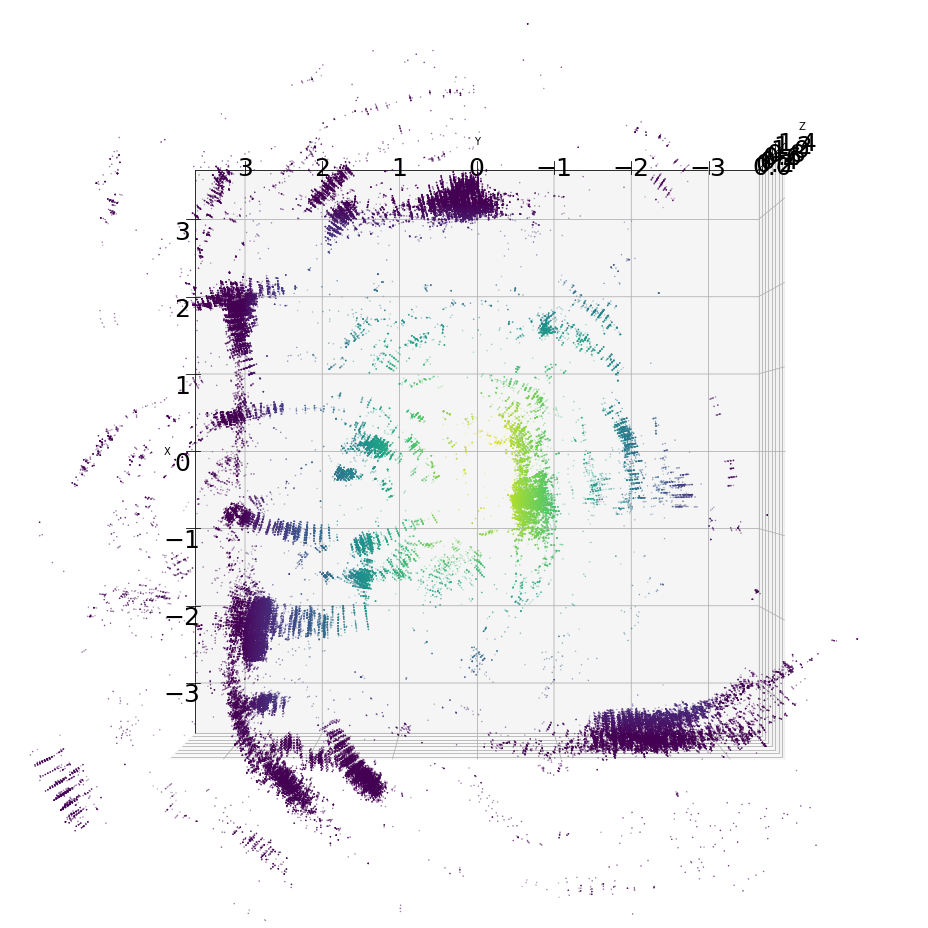

In [7]:

# ((pc[:, 0] > -3.81) & (pc[:, 1] > -3.38) & (pc[:, 0] < 3.95) & (pc[:, 1] < 3.2) & (pc[:, 2] >= 0)) & \
# ((pc[:, 0] < -3.61) | (pc[:, 1] < -3.18) | (pc[:, 0] > 3.15) | (pc[:, 1] > 3.0) & (pc[:, 2] < 4))

def inside_walls(abs_mmw):
    t_ = np.copy(abs_mmw[:, :3])
    p2bw_dist = np.multiply((0. > -3.61 - t_[:, 0]), np.abs(-3.61 - t_[:, 0]))   # Distance from Back Wall
    p2fw_dist = np.multiply((0. <  3.15 - t_[:, 0]), np.abs( 3.15 - t_[:, 0]))   # Distance from Front Wall
    p2lw_dist = np.multiply((0. <  3.00 - t_[:, 1]), np.abs( 3.00 - t_[:, 1]))   # Distance from Left Wall
    p2rw_dist = np.multiply((0. > -3.18 - t_[:, 1]), np.abs(-3.18 - t_[:, 1]))   # Distance from Right Wall
    p2ws = np.vstack([p2bw_dist, p2fw_dist, p2lw_dist, p2rw_dist]).T
    # print(p2ws.shape)
    return p2ws.min(axis=1)

def plot_2dscene(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    fig.set_tight_layout(True)
    ax = fig.add_subplot()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    ax.set_xlim([-3.5, 3.5])
    ax.set_ylim([-3.5, 3.5])
    # ax.set_zlim([0, 1.5])
    # ax.view_init(elev=90, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], s=pc_size, marker='.', c=colors)
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], 0.1, s=25, marker='o', c='orange')
        ax.scatter(path[1:-1, 0], path[1:-1,1], s=path_size, marker='.', c='orange')
        ax.scatter(path[-1, 0], path[-1, 1], 0.1, s=25, marker='x', c='orange')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)

#  | (-3.61 - t_[:, 0] >  0.2)
#  | ( 3.15 - t_[:, 0] < -0.8)
#  | ( 3.00 - t_[:, 0] < -0.2)
#  | (-3.18 - t_[:, 0] >  0.2)

# replace 0s with np.inf in p2ws
# p2ws[p2ws == 0] = np.inf
# p2O = np.hstack([p2o_dist, p2ws])
# print(p2O.shape)

# for _ in range(10):
#     print(p2ws[_], " || ", abs_mmw[_, :3])
p2ws = inside_walls(abs_mmw)
plot_scene(abs_mmw, colors=p2ws)
# plot_2dscene(abs_mmw, colors=p2ws)

39.01185162422449 139.97326770745414 -138.422513911009 -40.55347844119775
32135 73901 49313 20852  =  176201


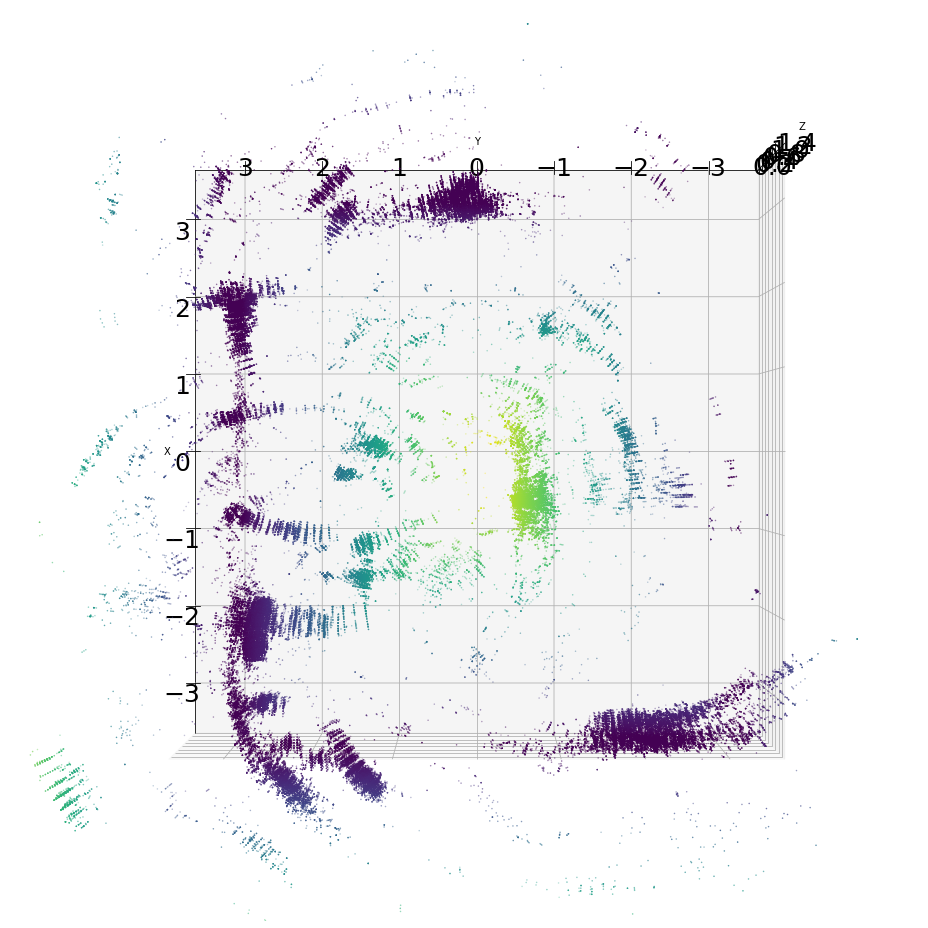

In [8]:

# ((pc[:, 0] > -3.81) & (pc[:, 1] > -3.38) & (pc[:, 0] < 3.95) & (pc[:, 1] < 3.2) & (pc[:, 2] >= 0)) & \
# ((pc[:, 0] < -3.61) | (pc[:, 1] < -3.18) | (pc[:, 0] > 3.15) | (pc[:, 1] > 3.0) & (pc[:, 2] < 4))
# def quad_dist(abs_mmw, box):
#     t_ = np.copy(abs_mmw[:, :3])
#     angles = np.arctan2(t_[:, 1], t_[:, 0])
#     q1 = np.logical_and(angles >= -np.pi/4, angles < np.pi/4)
#     q2 = np.logical_and(angles >= np.pi/4, angles < 3*np.pi/4)
#     q3 = np.logical_or(angles >= 3*np.pi/4, angles < -3*np.pi/4)
#     q4 = np.logical_and(angles >= -3*np.pi/4, angles < -np.pi/4)

#     dq1 = np.multiply(np.logical_and((box[0] < t_[:, 0]), q1), np.abs(box[0] - t_[:, 0]))   # Distance from Front Wall
#     dq2 = np.multiply(np.logical_and((box[1] > t_[:, 0]), q3), np.abs(box[1] - t_[:, 0]))   # Distance from Back Wall
#     dq3 = np.multiply(np.logical_and((box[2] < t_[:, 1]), q2), np.abs(box[2] - t_[:, 1]))   # Distance from Left Wall
#     dq4 = np.multiply(np.logical_and((box[3] > t_[:, 1]), q4), np.abs(box[3] - t_[:, 1]))   # Distance from Right Wall

#     dq = np.vstack([dq1, dq2, dq3, dq4]).T
#     return np.sum(dq, axis=1)

def quad_dist2(abs_mmw, box):
    t_ = np.copy(abs_mmw[:, :3])
    angles = np.arctan2(t_[:, 1], t_[:, 0])
    box_angle1 = np.arctan2(box[2], box[0])
    box_angle2 = np.arctan2(box[2], box[1])
    box_angle3 = np.arctan2(box[3], box[1])
    box_angle4 = np.arctan2(box[3], box[0])
    print(box_angle1*180/np.pi, box_angle2*180/np.pi, box_angle3*180/np.pi, box_angle4*180/np.pi)

    q1 = np.logical_and(angles >= box_angle4, angles < box_angle1)
    q2 = np.logical_and(angles >= box_angle1, angles < box_angle2)
    q3 = np.logical_or (angles >= box_angle2, angles < box_angle3)
    q4 = np.logical_and(angles >= box_angle3, angles < box_angle4)
    print(np.sum(q1), np.sum(q2), np.sum(q3), np.sum(q4), " = ", np.sum(q1)+np.sum(q2)+np.sum(q3)+np.sum(q4))

    dq1 = np.multiply((box[0] < t_[:, 0]) & q1, np.abs(box[0] - t_[:, 0]))   # Distance from Front Wall
    dq2 = np.multiply((box[1] > t_[:, 0]) & q3, np.abs(box[1] - t_[:, 0]))   # Distance from Back Wall
    dq3 = np.multiply((box[2] < t_[:, 1]) & q2, np.abs(box[2] - t_[:, 1]))   # Distance from Left Wall
    dq4 = np.multiply((box[3] > t_[:, 1]) & q4, np.abs(box[3] - t_[:, 1]))   # Distance from Right Wall

    dq = np.vstack([dq1, dq2, dq3, dq4]).T
    return np.sum(dq, axis=1)

dq = quad_dist2(abs_mmw, box = [3.95, -3.81, 3.20, -3.38])
wall_d = np.sum(np.vstack([dq, p2ws]).T, axis=1)
# # print(dq.max())
plot_scene(abs_mmw, colors=wall_d)
# # plot_scene(abs_mmw[np.logical_and((-3.81 > t_[:, 0]), q3)], colors=dq2[np.logical_and((-3.81 > t_[:, 0]), q3)])

76.23921488820876 103.76078511179124 -103.76078511179124 -76.23921488820876
25351 3693 122984 24173  =  176201
76.23921488820876 103.76078511179124 -103.76078511179124 -76.23921488820876
90757 2727 80419 2298  =  176201
76.23921488820876 103.76078511179124 -103.76078511179124 -76.23921488820876
54139 20100 93377 8585  =  176201
76.23921488820876 103.76078511179124 -103.76078511179124 -76.23921488820876
60946 3714 99976 11565  =  176201
76.39026810418781 103.6097318958122 -103.6097318958122 -76.39026810418781
118630 5592 34861 17118  =  176201
76.39026810418781 103.6097318958122 -103.6097318958122 -76.39026810418781
89884 34568 48280 3469  =  176201


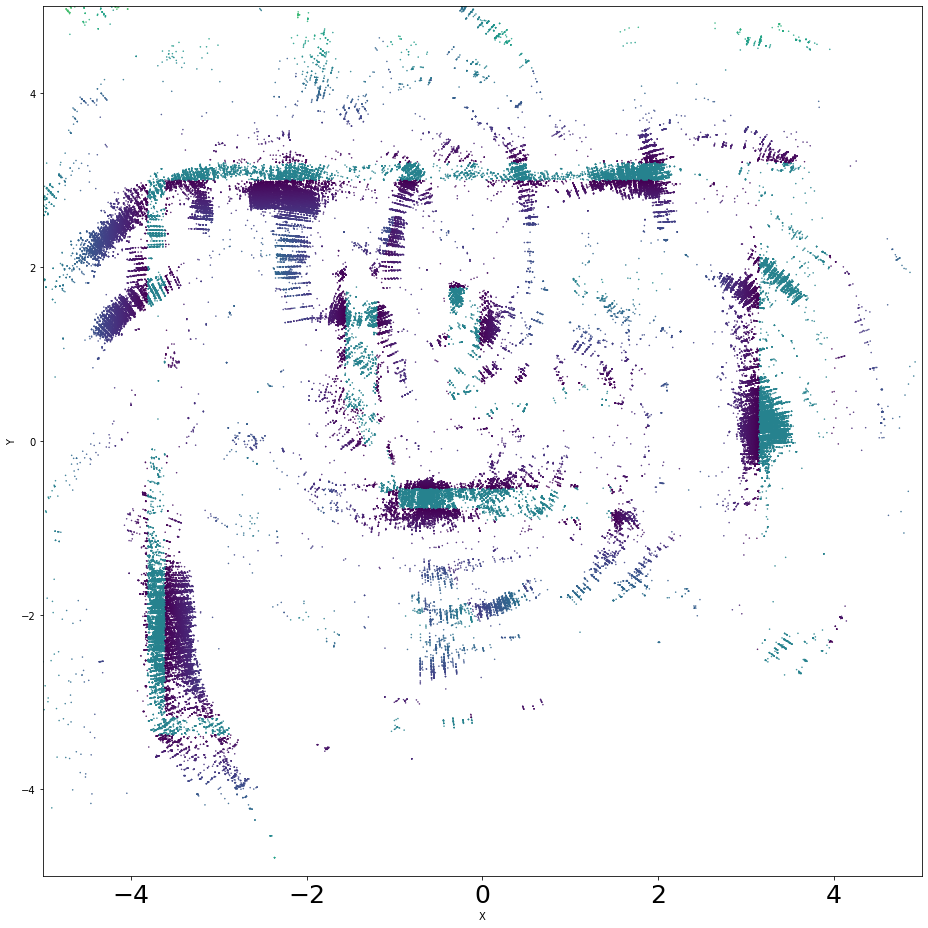

In [9]:


def obstacles_filter3(abs_mmw, pos, dims, tops, offset_x=VIC_OFF_X, offset_y=VIC_OFF_Y, verbose=False):

    tmp1 = np.array([False]*abs_mmw.shape[0])
    mmw_t = [abs_mmw[i:i+200] for i in range(0, abs_mmw.shape[0], 200)]
    dists = []

    i = 0
    for i in range(len(pos)):
        t = [[ 
            -(pos[i][0] - VIC_OFF_X), -(pos[i][1] - VIC_OFF_Y), (pos[i][2])
        ]]*(len(mmw_t))
        tmp_ = np.array(update_refer_frame(copy.deepcopy(mmw_t), copy.deepcopy(t), offset_x=0, offset_y=0))
        if verbose:
            print(" obs: ", tops[i], "pos(t)", t[0], " dims: ", dims[i])
            print(" pos: ", pos[i])
        tmp2 = np.where((
            (
                (tmp_[:, 0] > -dims[i][0]/2) & \
                (tmp_[:, 0] < dims[i][0]/2) \
            ) & \
            (
                (tmp_[:, 1] > -dims[i][1]/2) & \
                (tmp_[:, 1] < dims[i][1]/2) \
            )
        ))[0]
        tmp1[tmp2] = True
        
        x_ = quad_dist2(tmp_, box=[dims[i][0]/2, -dims[i][0]/2, dims[i][1]/2, -dims[i][1]/2])
        # x_[x_ == 0.] = 15
        # plot_scene(abs_mmw, colors=x_)
        # break
        dists.append(x_)
    dists = np.vstack(dists).T
    dists = dists.min(axis=1)
    return tmp1, dists

def plot_2dscene(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    fig.set_tight_layout(True)
    ax = fig.add_subplot()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    # ax.set_zlim([0, 1.5])
    # ax.view_init(elev=90, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], s=pc_size, marker='.', c=colors)
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], 0.1, s=25, marker='o', c='orange')
        ax.scatter(path[1:-1, 0], path[1:-1,1], s=path_size, marker='.', c='orange')
        ax.scatter(path[-1, 0], path[-1, 1], 0.1, s=25, marker='x', c='orange')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)

# Distance Metric Computation

# Point to Obstacle distance
tmp1, dists = obstacles_filter3(abs_mmw, pos, dims, tops, verbose=False)
# set 1 to the min values in p2o_dist for each row
# p2o_dist = np.int32(p2o_dist == p2o_dist.min(axis=1)[:, None])
# print(dists.max())
# dists[dists == 0.] = 5
dists = np.vstack([dists, wall_d]).T.min(axis=1)
dists[dists == 0.] = 1.1
dists = dists[:]*10000
plot_2dscene(abs_mmw, colors=dists)

 Loading:  run_3
 Loading Dataset:  run_3

 Available Data: 
  -  scene_ID
  -  init_pose
  -  run_total_time
  -  timestamp
  -  data_laser
  -  data_imu
  -  data_pose
  -  data_camera_image_path
  -  data_mmwave
  -  data_camera_depth_path
  -  missing_mmWave_idx
['/vicon/MediumObstacle1/MediumObstacle1', '/vicon/MediumObstacle2/MediumObstacle2', '/vicon/Obstacle7/Obstacle7', '/vicon/Obstacle4/Obstacle4', '/vicon/Obstacle5/Obstacle5', '/vicon/Obstacle6/Obstacle6']
 Run run_3 - Scene 1 - # Obstacles: 6 
 obs:  /vicon/MediumObstacle1/MediumObstacle1 pos(t) [0.7861000000000002, -1.2912, 0.011]  dims:  [0.36, 1.47, 0.25]
 pos:  [2.2138999999999998, 3.9912, 0.011]
 obs:  /vicon/MediumObstacle2/MediumObstacle2 pos(t) [-0.7534000000000001, -1.2767, 0.0147]  dims:  [0.36, 1.47, 0.25]
 pos:  [3.7534, 3.9767, 0.0147]
 obs:  /vicon/Obstacle7/Obstacle7 pos(t) [0.7909000000000002, -2.7477, 3.1337]  dims:  [0.49, 0.36, 0.25]
 pos:  [2.2091, 5.4477, 3.1337]
 obs:  /vicon/Obstacle4/Obstacle4 pos(t)

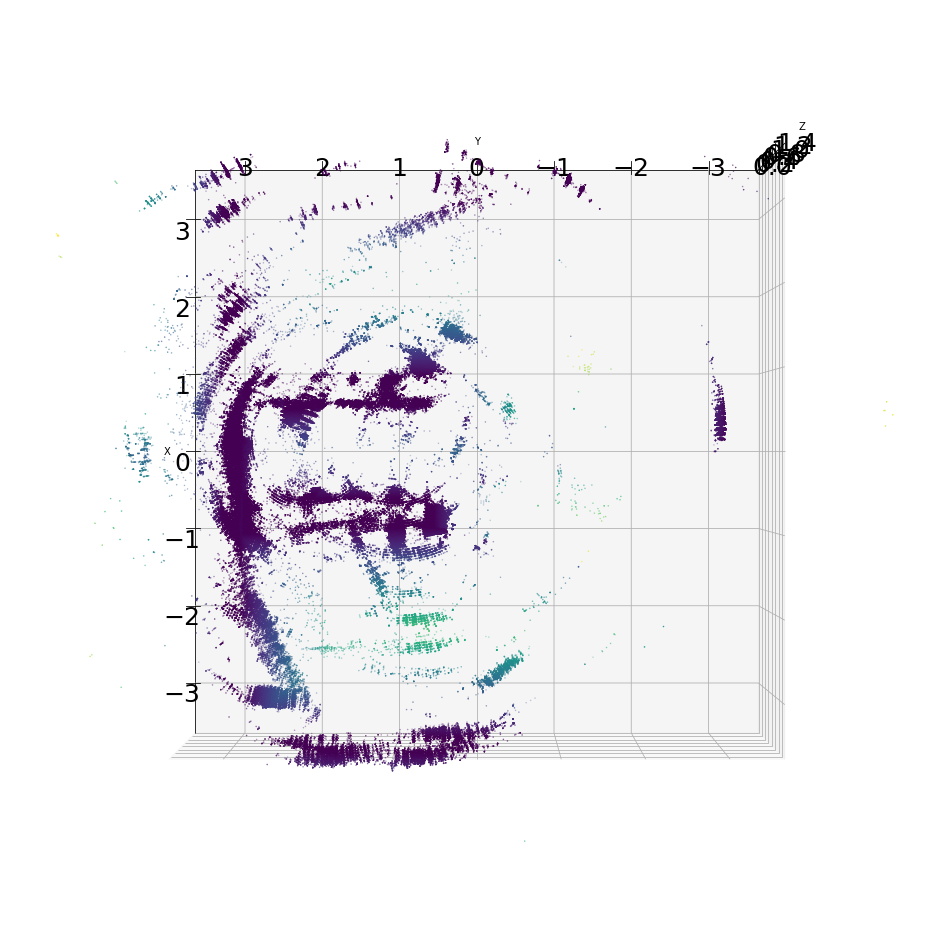

In [10]:
def compute_distv1(abs_mmw, pos, dims, tops, verbose=False):
    p2ws = inside_walls(abs_mmw)
    dq = quad_dist2(abs_mmw, box = [3.95, -3.81, 3.20, -3.38])
    wall_d = np.sum(np.vstack([dq, p2ws]).T, axis=1)
    tmp1, dists = obstacles_filter3(abs_mmw, pos, dims, tops, verbose=verbose)
    dists = np.vstack([dists, wall_d]).T.min(axis=1)
    # dists[dists == 0.] = 5
    return dists

def stack_labels_dists(mmw_readings, labels, dists):
    labelled_mmw = []
    counter = 0

    for i in range(len(mmw_readings)):
        current_size = len(mmw_readings[i])
        labelled_mmw.append(np.column_stack((mmw_readings[i], labels[counter:counter+current_size], dists[counter:counter+current_size])).tolist())
        counter += current_size
    return labelled_mmw


for dataset_index in list(datasets.keys())[0]:
    poses, abs_mmw, mmw_readings, data = load_dataset(datasets, dataset_index)
    labels, not_labels, pos, dims, tops = get_point_labels(datasets, dataset_index, path_to_json)
    dists = compute_distv1(abs_mmw, pos, dims, tops)
    stacked_mmw = stack_labels_dists(mmw_readings, labels, dists)
    # with open(path_to_json+"run_"+dataset_index+'/stacked_mmw_'+datasets[dataset_index]+'.json', 'w') as f:
    #     json.dump({'labelled_mmw': stacked_mmw}, f)
    plot_scene(abs_mmw, colors=dists)


 Generating obstacle  0  at  [2.2138999999999998, 3.9912, 0.011] with topic  /vicon/MediumObstacle1/MediumObstacle1
 Generating obstacle  1  at  [3.7534, 3.9767, 0.0147] with topic  /vicon/MediumObstacle2/MediumObstacle2
 Generating obstacle  2  at  [2.2091, 5.4477, 4.704496326794897] with topic  /vicon/Obstacle7/Obstacle7
 Generating obstacle  3  at  [3.7842000000000002, 5.4491, 1.5924963267948966] with topic  /vicon/Obstacle4/Obstacle4
 Generating obstacle  4  at  [3.7906, 4.9546, 1.5732963267948965] with topic  /vicon/Obstacle5/Obstacle5
 Generating obstacle  5  at  [2.1982, 4.9591, 4.710496326794896] with topic  /vicon/Obstacle6/Obstacle6


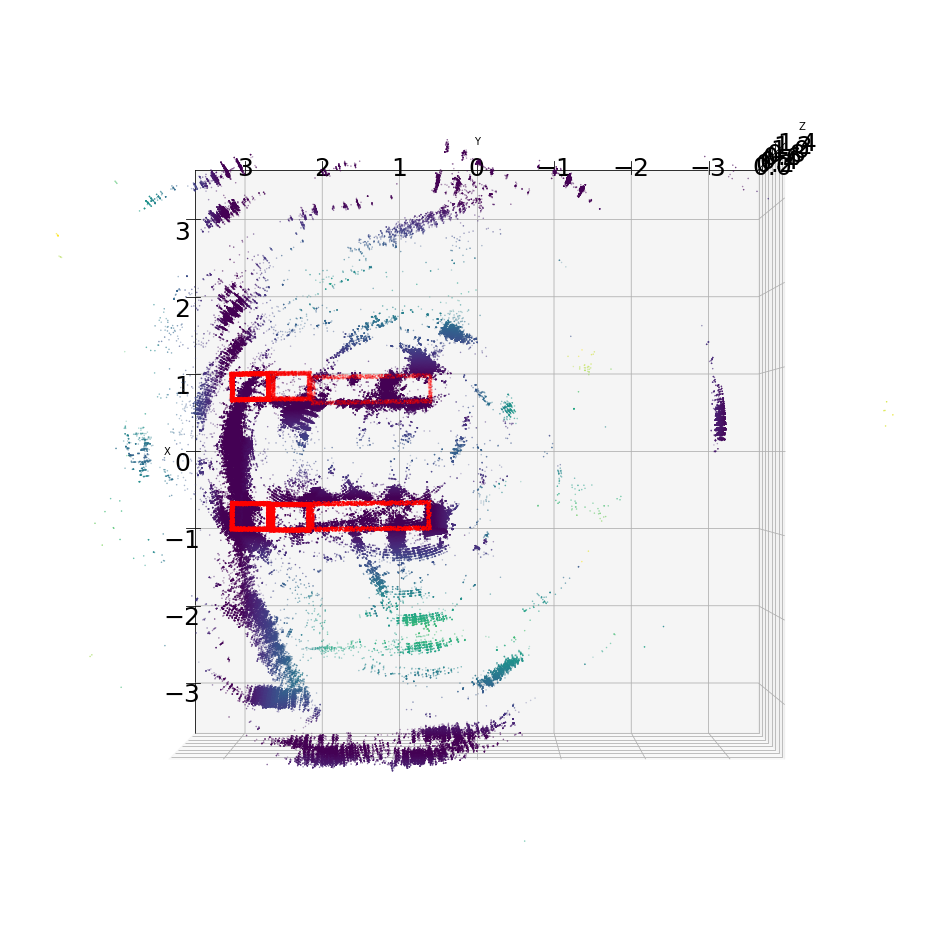

In [18]:

n_points = 5000
border = 0.05
scenes = get_scenes(path_to_json+"/scene/data_scene")
pos, dims, tops = get_obs_info(scenes[data["scene_ID"]])
abs_obstacles = generate_abs_bounding_obstacles(pos, dims, tops, n_points, border)
plot_scene(abs_mmw, obstacles=abs_obstacles, colors=dists)

In [ ]:

def label_mmw(mmw_readings, labels):
    labelled_mmw = []
    counter = 0

    for i in range(len(mmw_readings)):
        current_size = len(mmw_readings[i])
        labelled_mmw.append(np.column_stack((mmw_readings[i], labels[counter:counter+current_size])).tolist())
        counter += current_size
    return labelled_mmw

labelled_mmw = label_mmw(mmw_readings, labels)


In [ ]:
# with open('data/run'+dataset_index+'/labelled_mmw_'+datasets[dataset_index]+'.json', 'w') as f:
with open(path_to_json+"run"+dataset_index+'/labelled_mmw_'+datasets[dataset_index]+'.json', 'w') as f:
    json.dump({'labelled_mmw': labelled_mmw}, f)

## Normalize Dataset

 Skipped (Irregular or Without True Points) Point Clouds:  15
 True Obstacles: 54.53 
 False Obstacles: 45.47


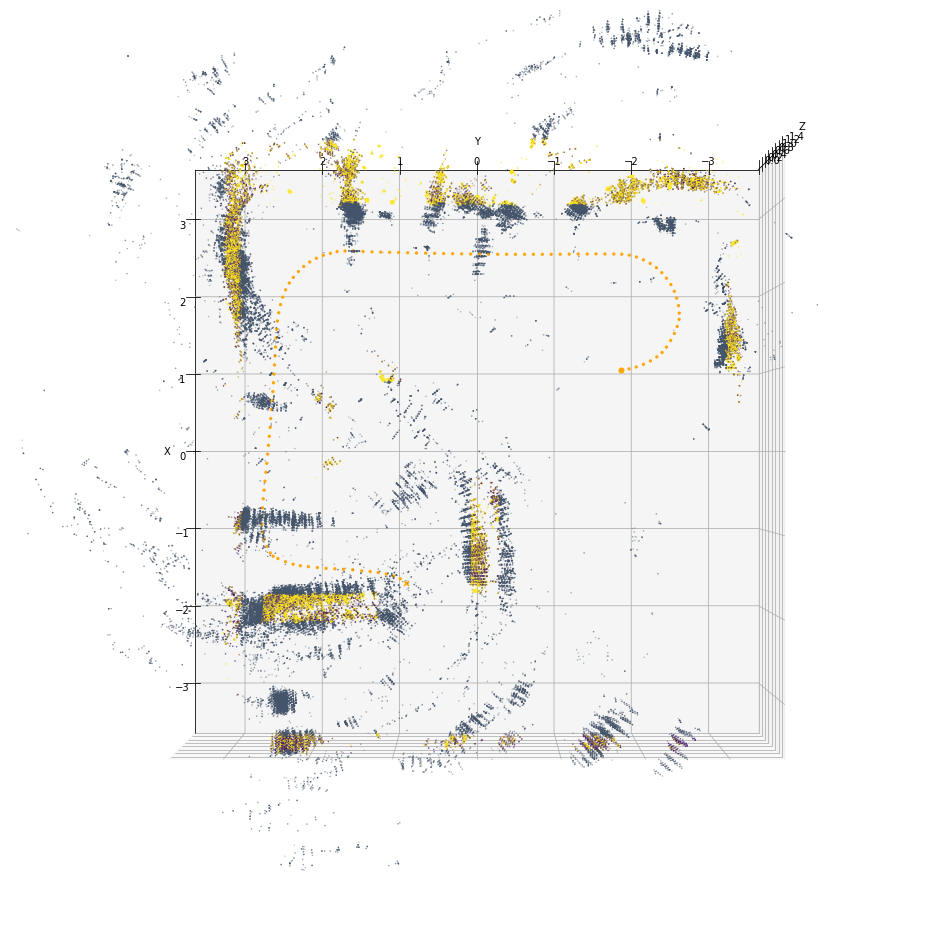

In [ ]:
def get_labels(pc, pos, dims, tops):
    labels = np.array([False]*pc.shape[0])
    surv_arena = arena_filter(pc)
    surv_obs = obstacles_filter2(pc, pos[:p], dims[:p], tops[:p])
    labels[surv_arena] = True
    labels[surv_obs] = True
    return labels

skip_pc = []
normalized_mmw = []

for p in range(0, abs_mmw.shape[0], 200):
    pc = abs_mmw[p:p+200]
    p += 1
    # labels = np.array([False]*pc.shape[0])
    # surv_arena = arena_filter(pc)
    # surv_obs = obstacles_filter2(pc, pos[:p], dims[:p], tops[:p])
    # labels[surv_arena] = True
    # labels[surv_obs] = True
    labels = get_labels(pc, i_pos, i_dims, tops)
    # print("N TRUE", np.sum(labels), len(labels), len(pc))
    if np.sum(labels) == 0 or len(pc) != 200:
        skip_pc.append(p//200)
    else:
        tmp = np.copy(pc)
        while np.sum(labels) < 100:
            new_true = 100 - np.sum(labels)
            # print(" WHERE", np.where(labels == False))
            false_toremove = np.random.choice(np.where(labels == False)[0], new_true, False)
            # print(tmp[labels].shape, (new_true, tmp[labels].shape[-1]))
            new_pc = []
            while len(new_pc) < new_true: new_pc.append(np.random.normal(tmp[labels], 0.01))
            new_pc = np.vstack(new_pc)[:new_true]
            # print(false_toremove.shape, new_pc.shape)
            tmp[false_toremove] = new_pc
            labels = get_labels(tmp, i_pos, i_dims, tops)
            # print(np.int32(labels))
            # tmp[:, -1] = np.int32(labels)
            tmp[false_toremove, 3] = 255
            tmp[false_toremove, 4] = 0.
        assert tmp.shape[0] == 200, "Adding too many points"
        normalized_mmw.append(tmp)

normalized_mmw = np.vstack(normalized_mmw)
# print(normalized_mmw.shape, abs_mmw.shape)
print(" Skipped (Irregular or Without True Points) Point Clouds: ", len(skip_pc))
# np.sum(labels)
norm_labels = get_labels(normalized_mmw, i_pos, i_dims, tops)
norm_not_labels = np.logical_not(norm_labels)
true_obs = np.sum(norm_labels)/len(norm_labels)
false_obs = np.sum(norm_not_labels)/len(norm_labels)
# print first 3 digits of true_obs and false_obs
print(" True Obstacles:", round(true_obs*100, 2), "\n False Obstacles:", round(false_obs*100, 2))
plot_scene(normalized_mmw[norm_labels, :], fake_points=normalized_mmw[norm_not_labels, :], path=poses)

In [ ]:
norm_mmw = []
counter = 0

for i in range(0, normalized_mmw.shape[0], 200):
    norm_mmw.append(np.column_stack((normalized_mmw[i:i+200, :], norm_labels[i:i+200])).tolist())
norm_mmw = np.vstack(norm_mmw)

In [ ]:
with open(path_to_json+'run'+dataset_index+'/norm_mmw_'+datasets[dataset_index]+'.json', 'w') as f:
    json.dump({'labelled_mmw': norm_mmw.tolist()}, f)

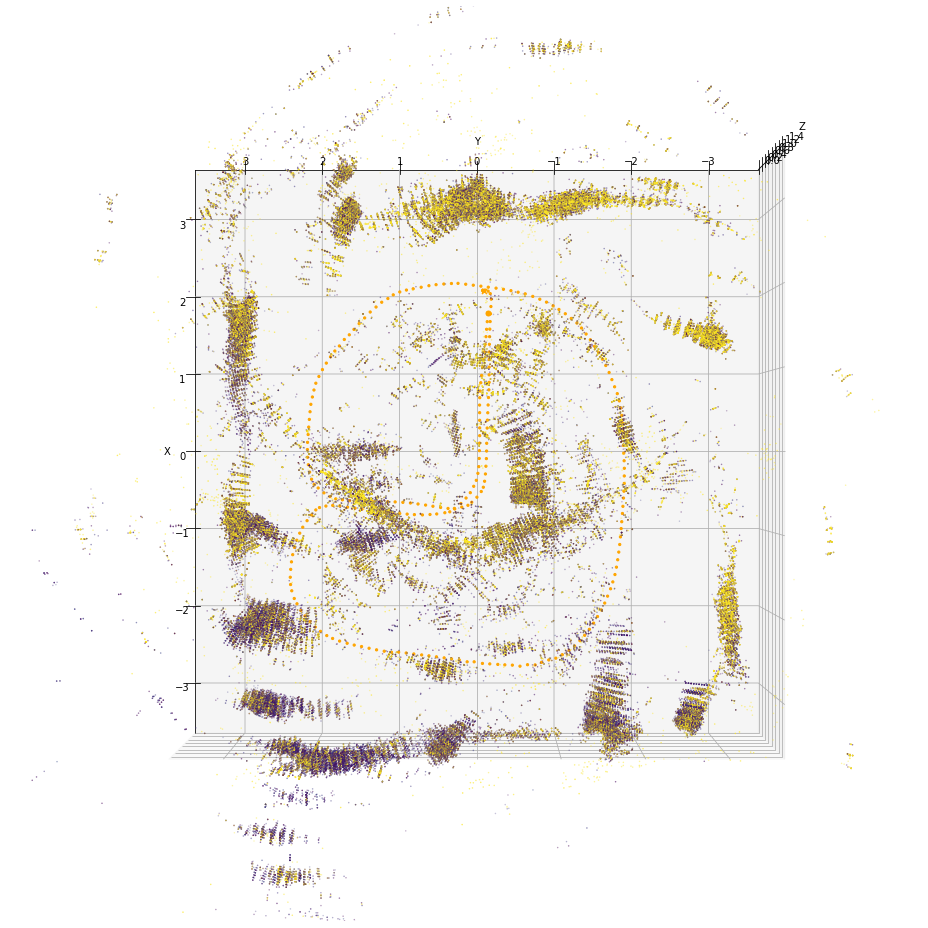

In [ ]:
%matplotlib inline
dest_path = os.path.join(path_to_json, datasets[dataset_index], datasets[dataset_index]+"_labelled_points.png")
# plot_scene(abs_mmw[labels, :], fake_points=abs_mmw[not_labels, :], path=poses, dest_path=dest_path)
plot_scene(abs_mmw, path=poses)

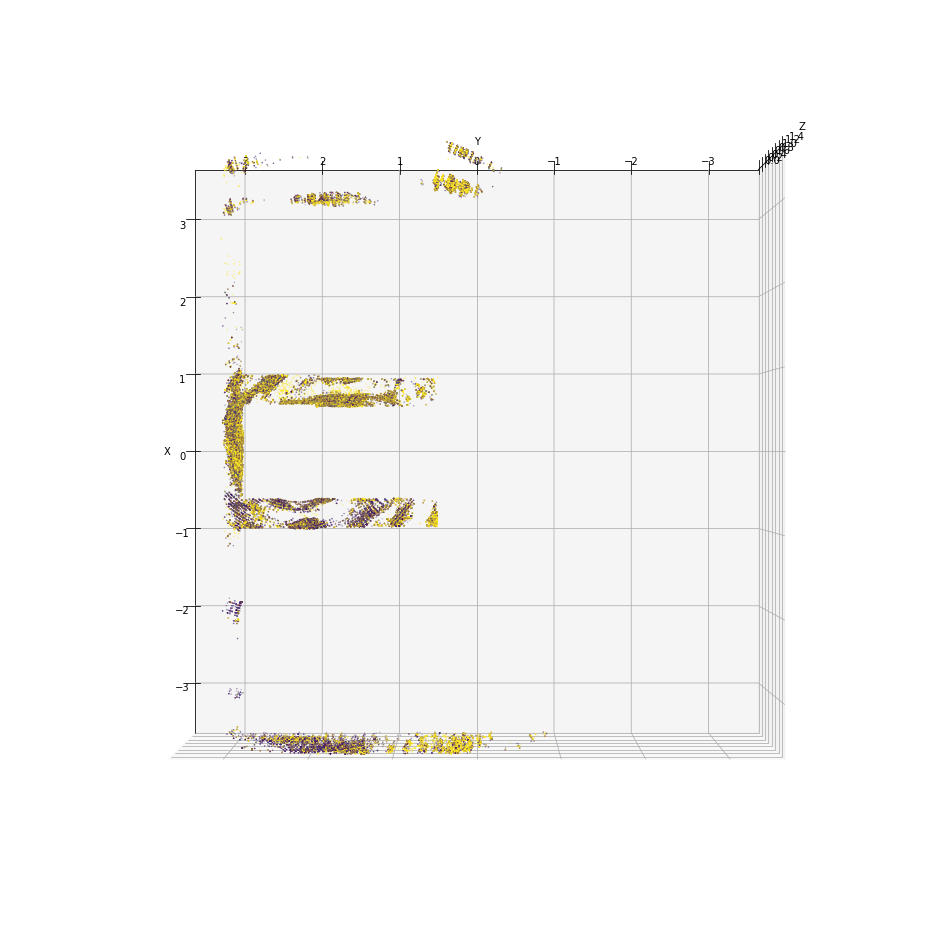

In [ ]:
%matplotlib inline
dest_path = os.path.join(path_to_json, datasets[dataset_index], datasets[dataset_index]+"_true_points.png")
plot_scene(abs_mmw[labels, :], dest_path=dest_path)

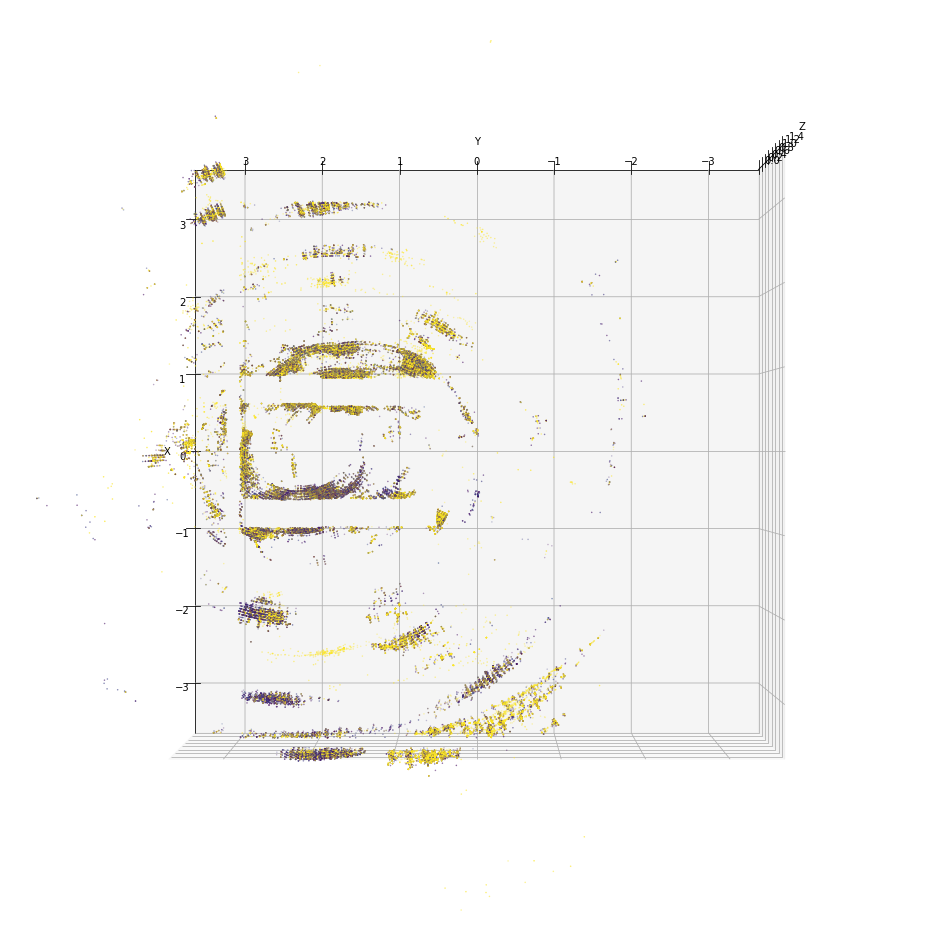

In [ ]:
%matplotlib inline
dest_path = os.path.join(path_to_json, datasets[dataset_index], datasets[dataset_index]+"_false_points.png")
plot_scene(abs_mmw[not_labels, :], dest_path=dest_path)

### Plot the trajectory followed during the run.

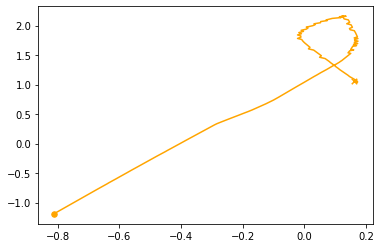

In [ ]:
%matplotlib inline
# Plot the Trajectory
plt.scatter(poses[0, 0], poses[0,1], s=30, marker='o', c='orange')
plt.plot(poses[1:-1, 0], poses[1:-1,1], c='orange')
plt.scatter(poses[-1, 0], poses[-1, 1], s=30, marker='x', c='orange')

## Apply some filtering

In [ ]:
# Filter points with intensity > avg(intensity)
# avg_intensity = np.mean(abs_mmw[:, 3])*1.2
# filt_mmw = abs_mmw[abs_mmw[:, 3] > avg_intensity]

raw_mmw = abs_mmw[abs_mmw[:, 3] < 255]
print(" Number of points (with AHC):      ", abs_mmw.shape[0])
print(" Number of points (without AHC):   ", raw_mmw.shape[0])


 Number of points (with AHC):       508463
 Number of points (without AHC):    223099


## The following block plots the whole point cloud (including points added by the AHC)

In [ ]:
%matplotlib qt
# With AHC
plot_scene(abs_mmw, obstacles = [], path = poses[:, :2])

## The following block plots the whole point cloud, filtering out the artificial points from AHC

The filtering applied as a threshold on the intensity: artificial points share the same intensity value (equal to 255), which is never reached by "natural" points

In [ ]:
%matplotlib qt
# Without AHC
plot_scene(raw_mmw, obstacles = [], path = poses[:, :2])

In [ ]:
orig_mmw = np.vstack(mmw_readings)

%matplotlib qt
# Plot each axis separately in subplots
fig, axs = plt.subplots(1, 3, figsize=(27, 9))
fig.set_tight_layout(True)
for ax in axs:
    ax.set_xlabel('N')

# Plot X-axis
axs[0].set_ylabel('X')
axs[0].plot(range(len(orig_mmw[:, 0])), orig_mmw[:, 0], '.')

# Plot Y-axis
axs[1].set_ylabel('Y')
axs[1].plot(range(len(orig_mmw[:, 1])), orig_mmw[:, 1], '.')

# Plot Z-axis
axs[2].set_ylabel('Z')
axs[2].plot(range(len(orig_mmw[:, 2])), orig_mmw[:, 2], '.')


# Experimental

In [ ]:
from networkx.algorithms import community
import networkx as nx
import scipy.cluster.hierarchy as hcluster
import itertools

def average_comm_dist(g, comm):
    for k, group in enumerate(comm):
        if len(group) > 1:
            d = 0
            for i in group:
                d += np.average([g.adj[i][j]['weight'] for j in group])
            d /= len(group)
        else:
            d = 0
        print(f" Group {k} - Avg. Dist: {d} ")

def communities_statistics(g, comms):
    print(" # Communities: ", len(comms))
    print(" Point Clouds per Community:")
    for i, comm in enumerate(comms): print(f" Group {i} - # pcs: {len(comm)}")
    print(" Average Distance of Point Clouds inside their communities:")
    average_comm_dist(g, comms)


# Edge metric based on distance
def edge_metric(d):
    return d+1e-16

# Edge metric based on 1/distance
def edge_metric_r(d):
    return np.clip(1/((d*1)+1e-16), -10, 10)

def build_pc_graph(pointcloud, edge_metric=edge_metric):
    # Compute distances of each point from the remaining ones
    edge_weights = [np.linalg.norm(np.subtract(v, pointcloud), axis=-1) for v in pointcloud]
    key_to_point = {i: pc for i, pc in enumerate(pointcloud)}
    edges = {j: {p: edge_metric(edge_weights[j][p]) for p in range(len(edge_weights[j]))} for j in range(np.array(edge_weights).shape[0])}
    
    g = nx.Graph()
    g.add_nodes_from(list(key_to_point.keys()))
    for i in list(edges.keys()):
        for j in list(edges[i].keys()):
            g.add_edge(i, j, weight=edges[i][j])
    
    return g, key_to_point


def agglomerative_filtering(pointcloud, threshold=0.75):
    clusters = hcluster.fclusterdata(pointcloud, threshold, criterion="distance")

    ### v ### Compute communities from clusters list ### v ###
    communities = []
    for i in list(set(clusters)):
        communities.append(np.where(clusters == i)[0])
    ### ^ ### ###################################### ### ^ ###

    # Compute average population of communities
    avg_pop = np.mean([len(comm) for comm in communities])
    survivors = []
    for comm in communities: 
        # Filter out communities with population below 25% of average
        if len(comm) > avg_pop*0.25: survivors.append(comm)

    return communities, clusters, survivors


# Load simple dataset to compute Community Detection analysis

In [ ]:
%matplotlib qt

idx_ = 100
# pc_list = np.vstack(abs_mmw)[:100, :3]
pc_list = np.vstack(mmw_readings)[200*idx_:200*idx_+200]
plot_scene(pc_list[labels[200*idx_:200*idx_+200], :], fake_points=pc_list[not_labels[200*idx_:200*idx_+200], :], pc_size=200, fake_pc_size=200, dest_path="OriginalPC.pdf")
# print(abs_mmw[labels, :][:200, :])
# plot_scene(abs_mmw[labels, :][:200, :], fake_points=abs_mmw[not_labels, :][:200, :], pc_size=100, fake_pc_size=100)
pc_list = pc_list[:, :3]

g1, key_to_point1 = build_pc_graph(pc_list, edge_metric=edge_metric)
g2, key_to_point2 = build_pc_graph(pc_list, edge_metric=edge_metric_r)
k = 200

# nx.draw(g, with_labels=True)
# pos = nx.spring_layout(g)
# nx.draw_networkx_edge_labels(g, pos)

In [ ]:

communities_generator = community.girvan_newman(g)
limited = itertools.takewhile(lambda c: len(c) <= k, communities_generator)

for communities in limited:
    print(tuple(sorted(c) for c in communities))

In [ ]:
%matplotlib qt
k = 200

gs = [[g1, key_to_point1, "dist"], [g2, key_to_point2, "1overdist"]]

for [g, key_to_point, label] in gs:
    for res in [1.0, 1.0005, 1.001]:
        print("\n\n", label, res, "\n\n")
        print(" Louvain Communities:")
        # comms = list(map(list, community.greedy_modularity_communities(g, weight="weight", resolution=res)))
        comms = list(map(list, community.louvain_communities(g, weight="weight", resolution=res)))
        communities_statistics(g, comms)
        colormap = plt.get_cmap('turbo')
        c = 1
        colors = np.zeros((len(key_to_point.keys()), len( colormap(0) ) ))
        for comm in comms:
            colors[comm] = colormap(c)
            c+=30
            
        plot_scene(pc_list, colors=colors, pc_size=100, dest_path=f"figures/louvain/louvain_{label}_res{str(res).replace('.', '')}.pdf")

# print("\n Louvain Communities:")
# comms = list(map(list, community.louvain_communities(g, weight="weight", resolution=1.001)))
# communities_statistics(g, comms)



# Interrupted after 12 minutes
# print("\n Naive Greedy Modularity Communities:")
# comms = list(map(list, community.naive_greedy_modularity_communities(g, weight="weight")))
# communities_statistics(g, comms)



 dist 1.0 


 Louvain Communities:
 # Communities:  1
 Point Clouds per Community:
 Group 0 - # pcs: 200
 Average Distance of Point Clouds inside their communities:
 Group 0 - Avg. Dist: 1.631205068375613 


 dist 1.0005 


 Louvain Communities:
 # Communities:  5
 Point Clouds per Community:
 Group 0 - # pcs: 41
 Group 1 - # pcs: 37
 Group 2 - # pcs: 41
 Group 3 - # pcs: 40
 Group 4 - # pcs: 41
 Average Distance of Point Clouds inside their communities:
 Group 0 - Avg. Dist: 1.6248490292089326 
 Group 1 - Avg. Dist: 1.6468770932828733 
 Group 2 - Avg. Dist: 1.6242962444883673 
 Group 3 - Avg. Dist: 1.6319512728520629 
 Group 4 - Avg. Dist: 1.6233027503293695 


 dist 1.001 


 Louvain Communities:
 # Communities:  9
 Point Clouds per Community:
 Group 0 - # pcs: 27
 Group 1 - # pcs: 41
 Group 2 - # pcs: 28
 Group 3 - # pcs: 13
 Group 4 - # pcs: 10
 Group 5 - # pcs: 13
 Group 6 - # pcs: 13
 Group 7 - # pcs: 27
 Group 8 - # pcs: 28
 Average Distance of Point Clouds inside their commun

In [ ]:

comms = list(map(list, community.greedy_modularity_communities(g, weight="weight", resolution=res)))

In [ ]:
# Just in Case: https://stackoverflow.com/questions/10136470/unsupervised-clustering-with-unknown-number-of-clusters
%matplotlib qt

comms, clusters, survivors = agglomerative_filtering(pc_list)

communities_statistics(g1, comms)
# print(" Survivors (all points in big enough communities): ")
# communities_statistics(g1, survivors)
# plotting
# print(list(set(clusters)))
# plot_scene(pc_list[np.hstack(survivors), :], colors=np.multiply(clusters[np.hstack(survivors)],20), pc_size=100)#, dest_path="figures/agglomerative/agglomerative.pdf")
colormap = plt.get_cmap('turbo')
c = 1
colors = np.zeros((len(key_to_point.keys()), len( colormap(0) ) ))
for comm in comms:
    colors[comm] = colormap(c)
    c+=30
    
plot_scene(pc_list, colors=colors, pc_size=100, dest_path="figures/agglomerative/agglomerative.pdf")
# plot_scene(pc_list[:200, :], colors=np.multiply(clusters[np.hstack(survivors)],20), pc_size=100)#, dest_path="figures/agglomerative/agglomerative.pdf")

# Agglomerative Clustering for filtering
Here Agglomerative Clustering is used for detecting communities.
The communities which have less than 25% points of average point clouds are filtered out.

In [ ]:
%matplotlib qt

aggl_mmw = []
for i, pc in enumerate(mmw_readings):
    # _, key_to_point = build_pc_graph(pc[:,:3])
    key_to_point = {i: pc for i, pc in enumerate(pc)}
    _, _, survivors = agglomerative_filtering(pc[:,:3])
    aggl_mmw.append(np.vstack([key_to_point[j] for j in np.hstack(survivors)]))
aggl_mmw = np.vstack(aggl_mmw)

print(" Filtrati: ", abs_mmw.shape[0] - aggl_mmw.shape[0])

 Filtrati:  14975


In [ ]:
import csv

header = ["x", "y", "z", "intensity", "velocity", "label"]

# dataset_fn = "data/labelled_data_"+datasets[dataset_index]+".csv"
dataset_fn = "data/labelled_data.csv"

has_header = False
if os.path.exists(dataset_fn):
    with open(dataset_fn, 'r') as csvfile:
        sniffer = csv.Sniffer()
        has_header = sniffer.has_header(csvfile.read(2048))

with open(dataset_fn, "a+") as file:
    csvw = csv.writer(file)
    if not has_header: csvw.writerow(header)
    for i in range(len(labels)):
        csvw.writerow(np.hstack((mmw_readings_np[i], labels[i])))

In [ ]:

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

import optuna
import numpy as np
from scipy import stats
import json
import os

def gnn_conv2d(inputs,
            filters,
            kernel_size,
            stride=[1, 1],
            padding='SAME',
            use_xavier=False,
            stddev=1e-3,
            activation_fn=tf.nn.elu,
            bn=False):

    x = layers.Conv2D(
        filters, 
        kernel_size, 
        strides=stride, 
        padding=padding,
        activation=activation_fn,
        kernel_initializer='glorot_uniform' if use_xavier else keras.initializers.TruncatedNormal(stddev=stddev),
        bias_initializer='zeros'
    )(inputs)

    if bn: x = layers.BatchNormalization()(x)
    return x

def gnn_dense(inputs,
            units,
            use_xavier=False,
            stddev=1e-3,
            activation_fn=tf.nn.elu,
            bn=False):
            
    x = layers.Dense(units,
        activation=activation_fn,
        kernel_initializer='glorot_uniform' if use_xavier else keras.initializers.TruncatedNormal(stddev=stddev),
        bias_initializer='zeros'
    )(inputs)

    if bn: x = layers.BatchNormalization()(x)
    return x

def lambda_get_adj_matr(input):
    pcT = layers.Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1]))(input)
    pc_inn = layers.Lambda(lambda x: tf.matmul(x[0], x[1]))( (input, pcT) )
    pc2 = layers.Lambda(lambda x: tf.reduce_sum(tf.square(x), axis=-1, keepdims=True))(input)
    pc2T = layers.Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1]))(pc2)
    output = layers.Lambda(lambda x: x[0] + -2 * x[1] + x[2])( (pc2, pc_inn, pc2T) )
    # output = layers.Lambda(lambda x: tf.math.reciprocal(x))(output)
    return output

def lambda_knn(adj, k=20):
    # _, nn_idxs = tf.nn.top_k(-adj, k)
    x = layers.Lambda(lambda x: tf.math.top_k(-x[0], x[1]))( (adj, k) )
    # x = layers.Lambda(lambda x: tf.math.top_k(x[0], x[1]))( (adj, k) )
    return x.indices

def lambda_edge_feature(inputs, nn_idxs, k=20, num_points=200, num_dims=3):

    pc_central = inputs
    batch_size = tf.shape(inputs)[0]

    idx_ = layers.Lambda(lambda x: tf.range(x[0]) * x[1])( (batch_size, num_points) )
    idx_ = layers.Lambda(lambda x: tf.reshape(x[0], (x[1], 1, 1)))( (idx_, batch_size) )
    pc_temp1 = layers.Lambda(lambda x: x[0]+x[1])( (nn_idxs, idx_) ) # Aggiungo alla lista (di indici) dei k punti più vicini i punti stessi

    pc_flat = layers.Lambda(lambda x: tf.reshape(x[0], [-1, x[1]]))( (inputs, num_dims) ) # Flat di tutti i punti per averli in una lista di coordinate (x,y,z)

    pc_neighbors = layers.Lambda(lambda x: tf.gather(x[0], x[1]) )( (pc_flat, pc_temp1) ) # prendo i 20 punti più vicini per ogni punto nella nuvola

    pc_central = layers.Lambda(lambda x: tf.expand_dims(x, axis=-2))(pc_central) # Espando la nuvola punti in ingresso nella shape (batch, num_points, NEW_AXIS(1), num_dims)
    pc_central = layers.Lambda(lambda x: tf.tile(x[0], [1, 1, x[1], 1]))( (pc_central, k) ) # Ripeto ogni punto k volte lungo la nuova dimensione ==> (batch, num_points, k, num_dims)

    pc_temp2 = layers.Lambda(lambda x: tf.subtract(x[0], x[1]))( (pc_neighbors, pc_central) )
    edge_feature = layers.Lambda(lambda x: tf.concat((x[0], x[1]), axis=-1))((pc_central, pc_temp2))
    # edge_feature = layers.Lambda(lambda x: tf.transpose(x, [0, 2, 1, 3]))( (edge_feature) )
    return edge_feature

    # x = gnn_conv2d(x, filters=256, kernel_size=[1,1], bn=bn)
    # x = layers.MaxPool2D(pool_size=[num_points,1], strides=[2,2], padding="VALID")(x)
    # print(" MAX POOLED: ", x.shape)
    # x = layers.Lambda(lambda y: tf.reshape(y[0], (y[1], -1)))( [x, batch_size] )
    # x = layers.Reshape((batch_size, -1))(x)
    # print(" RESHAPED TO: ", x.shape)

    # x = layers.Lambda(lambda x: tf.squeeze(x, -1))( x )
    # feat_T = layers.Lambda(lambda x: tf.reshape(x, (num_dims, num_dims)))( x )
    # return layers.Dot(axes=(-1, -2))([inputs, feat_T])

def gnn_tnet(inputs, num_points, num_dims, bn=False):
    batch_size = tf.shape(inputs)[0]

    x = gnn_conv2d(inputs, filters=32, kernel_size=[1,1], bn=bn)
    x = tf.reduce_max(x, axis=-2, keepdims=True)
    x = gnn_conv2d(x, filters=128, kernel_size=[1,1], bn=bn)
    x = layers.GlobalMaxPooling2D(keepdims=True)(x)
    x = layers.Lambda(lambda y: tf.reshape(y[0], (y[1], y[2])))( [x, batch_size, x.shape[-1]] )
    x = gnn_dense(x, 128, bn)
    x = gnn_dense(x, 128, bn)
    
    bias = keras.initializers.Constant(np.eye(num_dims).flatten())
    x = layers.Dense(
        num_dims * num_dims,
        kernel_initializer="zeros",
        bias_initializer=bias,
    )(x)
    feat_T = layers.Reshape((num_dims, num_dims))(x)
    return feat_T

####################################################################################################################

inputs = keras.Input(shape=(None, 3))
k=30
batch_size=16
num_points=200
num_dims=3
# test_pc = train_x[:batch_size] #np.expand_dims(train_x[0], axis=0)

adj = lambda_get_adj_matr(inputs)
nn_idxs = lambda_knn(adj, k)
edge_feats = lambda_edge_feature(inputs, nn_idxs, k, num_points, num_dims)
feat_T = gnn_tnet(edge_feats, num_points, num_dims, bn=True)
pc_tf = layers.Dot(axes=(-1, -2))([inputs, feat_T]) # Apply affine transformation to input features

adj = lambda_get_adj_matr(pc_tf)
nn_idxs = lambda_knn(adj, k)
edge_feats = lambda_edge_feature(pc_tf, nn_idxs, k, num_points, num_dims)

x = gnn_conv2d(edge_feats, 32, [1,1], bn=True)
x = gnn_conv2d(edge_feats, 64, [1,1], bn=True)
# x = gnn_conv2d(edge_feats, 256, [1,1], bn=True)
x = tf.reduce_max(x, axis=-2, keepdims=True)
x = layers.Lambda(lambda y: tf.reshape(y[0], (y[1], num_points, 64)))( [x, tf.shape(inputs)[0]] )

adj = lambda_get_adj_matr(x)
nn_idxs = lambda_knn(adj, k)
edge_feats = lambda_edge_feature(x, nn_idxs, k, num_points, 64)
x = gnn_conv2d(edge_feats, 128, [1,1], bn=True)
x = tf.reduce_max(x, axis=-2, keepdims=True)
x = layers.Lambda(lambda y: tf.reshape(y[0], (y[1], num_points, 128)))( [x, tf.shape(inputs)[0]] )

# adj = lambda_get_adj_matr(x)
# nn_idxs = lambda_knn(adj, k)
# edge_feats = lambda_edge_feature(x, nn_idxs, k, num_points, 256)
# x = gnn_conv2d(edge_feats, 64, [1,1], bn=True)
# x = tf.reduce_max(x, axis=-2, keepdims=True)
# x = layers.Lambda(lambda y: tf.reshape(y[0], (y[1], num_points, 64)))( [x, tf.shape(inputs)[0]] )

x = gnn_dense(x, 256, bn=True)
x = gnn_dense(x, 128, bn=True)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=[inputs], outputs=outputs, name="gnn_pointnet")

def custom_loss(pred, labels):
    # print(" SHAPES: ", labels.shape, pred.shape)
    # loss = tf.compat.v1.losses.softmax_cross_entropy(onehot_labels=labels, logits=pred, label_smoothing=0.2)
    # classify_loss = tf.reduce_mean(loss)
    loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(tf.math.subtract(labels, pred)), axis=-1))
    return loss

opt_pi = tf.optimizers.Adam(learning_rate =  0.001, beta_1=0.999, beta_2=0.9999 )
# opt_pi = tf.optimizers.RMSprop(learning_rate =  0.001 )
# model.compile(loss=tf.nn.sparse_softmax_cross_entropy_with_logits , optimizer=opt_pi, metrics=['accuracy'])
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=opt_pi, metrics=[keras.metrics.SparseCategoricalAccuracy()])


In [ ]:

test_name = "test_mm_1"
experiments_path="experiments/"

class ValAccThresh_CB(keras.callbacks.Callback):
    def __init__(self, thresh=0.85, experiments_path="experiments/", test_name="test"):
        self.thresh = thresh
        super(keras.callbacks.Callback, self).__init__()
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
        self.current_epoch = 0
        self.experiments_path = experiments_path
        self.test_name = test_name

    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch += 1
        val_key = ""
        for k in logs.keys():
            if "val" in k and "accuracy" in k:
                val_key = k
                break
        if val_key == "": print(" Validation Accuracy key not found.")

        current = logs.get(val_key)
        # current = logs.get("val_accuracy")
        if current >= self.thresh:
            self.thresh = current
            self.model.save_weights(self.experiments_path+self.test_name+"/best_weights/cp-"+str(epoch)+".ckpt")
            print(" New good model saved.")


filename=experiments_path+test_name+"/history.csv"
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

steps_per_epoch = 50
validation_steps = 25

checkpoint_path = experiments_path+test_name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    save_freq=10*steps_per_epoch)
    
latest = tf.train.latest_checkpoint(experiments_path+test_name+"/")
if latest:
    model.load_weights(latest)
    latest_ep = int(latest.split('/')[-1].split('-')[-1].split('.')[0])
    print(" Model loaded correctly:", latest, " - Epoch ", latest_ep)
else:
    print(" The model could not be loaded properly: ", latest)
    model.save_weights(checkpoint_path.format(epoch=0))
    latest_ep = 0

 Model loaded correctly: experiments/test_mm_1/cp-1000.ckpt  - Epoch  1000


In [ ]:
idx = 20
print(pc_list.shape)
out = np.argmax(model.predict(np.reshape(pc_list, (1, 200, 3))), axis=-1)[0]
# for _ in range(200):
#     print(out[_], labels[200*idx_:200*idx_+200][_], not_labels[200*idx_:200*idx_+200][_])
print(np.sum(out), np.sum(np.logical_not(out)))
print(np.sum(labels[200*idx_:200*idx_+200]), np.sum(not_labels[200*idx_:200*idx_+200]))

plot_scene(pc_list[out, :], fake_points=pc_list[np.logical_not(out), :], pc_size=200, fake_pc_size=200, dest_path="figures/gnn/prediction.pdf")
# plot_scene(pc_list[labels[200*idx_:200*idx_+200], :], fake_points=pc_list[not_labels[200*idx_:200*idx_+200], :], pc_size=200, fake_pc_size=200)#, dest_path="OriginalPC.pdf")

# total = 0
# for x in np.argwhere(out != 0):
#     if x in np.argwhere(test_y[idx] != 0): total += 1

"""
 TP | FN
----|----
 FP | TN
"""
print(tf.math.confusion_matrix(labels=labels[200*idx_:200*idx_+200], predictions=out, num_classes=2))

# print(f" True Total: {total}/{np.sum(test_y[idx] != 0)} ")
# print(" Predictions: ", np.argwhere(out != 0))
# print(" Labels", np.argwhere(test_y[idx] != 0))